# LSTM Multivariate


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings

# Ignore only DeprecationWarnings
warnings.filterwarnings('ignore')

In [4]:
import utils
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [5]:
session = utils.create_session()

df = session.table("company_revenue_time_series_2") #with cutoff
df = df.to_pandas()


df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

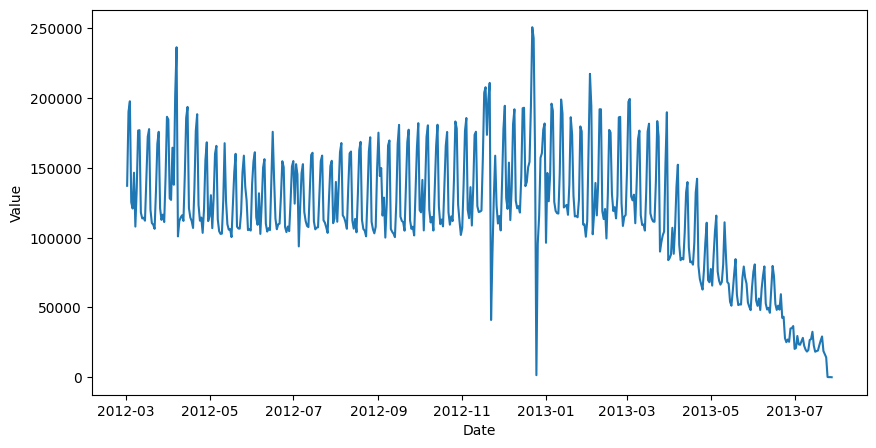

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Values')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

In [7]:
data = df['y'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

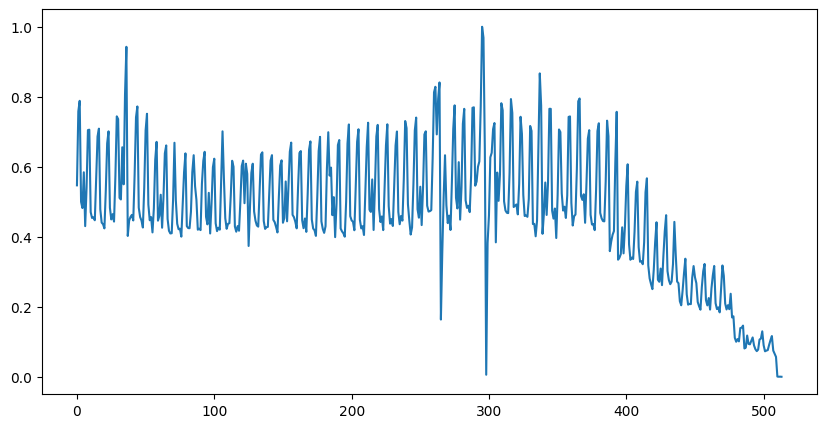

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(scaled_data)
plt.show()

In [66]:
from sklearn.preprocessing import StandardScaler
day_of_week = df['ds'].dt.dayofweek.values
day_of_week = day_of_week.reshape(-1, 1)
day_of_week_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(day_of_week)
print(day_of_week_scaled)

[[0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]
 [0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83

In [67]:
data = {
    'y': scaled_data.flatten(),
    'day_of_week': day_of_week_scaled.flatten()
}

In [84]:
df_train = pd.DataFrame(data)

,y,day_of_week
0,0.546967,0.666667
1,0.758278,0.833333
2,0.788419,1.000000
3,0.499867,0.000000
4,0.482075,0.166667
...,...,...
509,0.056853,0.333333
510,0.000570,0.500000
511,0.000186,0.666667
512,0.000318,0.833333


In [85]:
def create_sequences(df, time_step):
    X, y = [], []
    for i in range(len(df) - time_step):
        seq = df[['y', 'day_of_week']].iloc[i:i+time_step].values
        X.append(seq)
        y.append(df['y'].iloc[i+time_step])
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

time_step = 60 
X, y = create_sequences(df_train, time_step)
X

tensor([[[5.4697e-01, 6.6667e-01],
         [7.5828e-01, 8.3333e-01],
         [7.8842e-01, 1.0000e+00],
         ...,
         [6.2019e-01, 8.3333e-01],
         [6.7121e-01, 1.0000e+00],
         [4.4610e-01, 0.0000e+00]],

        [[7.5828e-01, 8.3333e-01],
         [7.8842e-01, 1.0000e+00],
         [4.9987e-01, 0.0000e+00],
         ...,
         [6.7121e-01, 1.0000e+00],
         [4.4610e-01, 0.0000e+00],
         [4.5972e-01, 1.6667e-01]],

        [[7.8842e-01, 1.0000e+00],
         [4.9987e-01, 0.0000e+00],
         [4.8207e-01, 1.6667e-01],
         ...,
         [4.4610e-01, 0.0000e+00],
         [4.5972e-01, 1.6667e-01],
         [5.2008e-01, 3.3333e-01]],

        ...,

        [[2.6741e-01, 0.0000e+00],
         [2.1363e-01, 1.6667e-01],
         [2.0136e-01, 3.3333e-01],
         ...,
         [6.6070e-02, 1.6667e-01],
         [5.6853e-02, 3.3333e-01],
         [5.7040e-04, 5.0000e-01]],

        [[2.1363e-01, 1.6667e-01],
         [2.0136e-01, 3.3333e-01],
         [1.

In [78]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, num_layers=2, output_size=1):
        super(MultivariateLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [79]:
# Instantiate the model
model = MultivariateLSTM(input_size=2)

# Set up training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000

# Train the model
for epoch in range(epochs):
    model.train()
    outputs = model(X)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/1000], Loss: 0.2531
Epoch [10/1000], Loss: 0.0961
Epoch [20/1000], Loss: 0.0451
Epoch [30/1000], Loss: 0.0321
Epoch [40/1000], Loss: 0.0307
Epoch [50/1000], Loss: 0.0300
Epoch [60/1000], Loss: 0.0287
Epoch [70/1000], Loss: 0.0275
Epoch [80/1000], Loss: 0.0260
Epoch [90/1000], Loss: 0.0234
Epoch [100/1000], Loss: 0.0185
Epoch [110/1000], Loss: 0.0165
Epoch [120/1000], Loss: 0.0148
Epoch [130/1000], Loss: 0.0141
Epoch [140/1000], Loss: 0.0136
Epoch [150/1000], Loss: 0.0134
Epoch [160/1000], Loss: 0.0132
Epoch [170/1000], Loss: 0.0130
Epoch [180/1000], Loss: 0.0129
Epoch [190/1000], Loss: 0.0128
Epoch [200/1000], Loss: 0.0128
Epoch [210/1000], Loss: 0.0127
Epoch [220/1000], Loss: 0.0126
Epoch [230/1000], Loss: 0.0125
Epoch [240/1000], Loss: 0.0124
Epoch [250/1000], Loss: 0.0123
Epoch [260/1000], Loss: 0.0122
Epoch [270/1000], Loss: 0.0120
Epoch [280/1000], Loss: 0.0117
Epoch [290/1000], Loss: 0.0114
Epoch [300/1000], Loss: 0.0110
Epoch [310/1000], Loss: 0.0103
Epoch [320/1000], L

In [72]:
def make_predictions(model, X_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predictions = scaler.inverse_transform(predictions.numpy())
    return predictions

In [80]:
X_input, y = create_sequences(df_train, time_step)
X_input_tensor = torch.tensor(X_input, dtype=torch.float32)

predictions = make_predictions(model, X_input_tensor)

In [74]:
def plot_predictions(predictions, y_test, time_step):
    adjusted_y_test = y_test[time_step:time_step + len(predictions)]
    plt.plot(range(time_step, len(y_test)), adjusted_y_test, label="ndarray Values")
    plt.plot(range(time_step, time_step + len(predictions)), predictions, label="ndarray Values")
    plt.show()

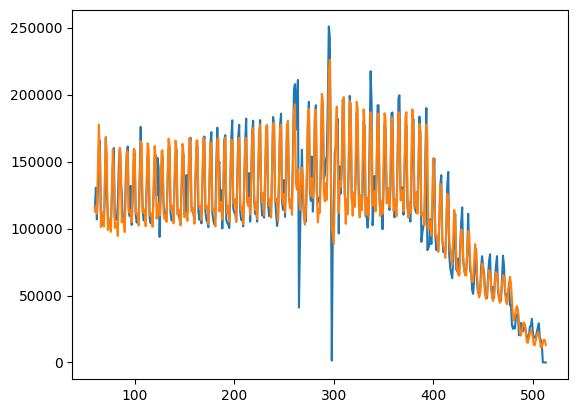

In [81]:
plot_predictions(predictions, df['y'], time_step)


In [90]:
y_test = df['y']
mape_score_all = utils.mape(predictions, y_test[time_step:])
mape_score_comp = utils.mape(predictions[len(predictions)-90:], y_test[len(y_test)-90:])


print(f"MAPE score = {mape_score_all}")
print(f"MAPE score last 90 = {mape_score_comp}")

MAPE score = 75.5
MAPE score last 90 = 86.32


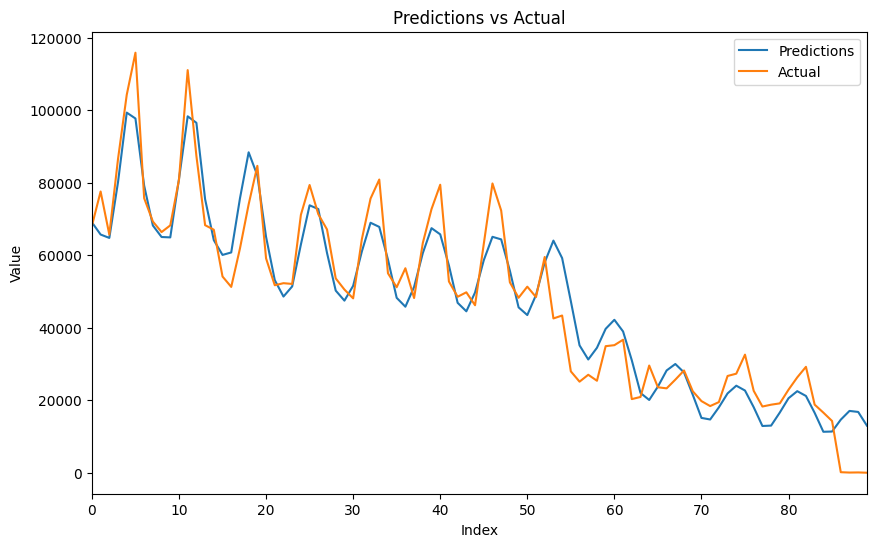

In [91]:
plt.figure(figsize=(10, 6))

# Define the range for the last 90 points
x_range = range(len(predictions[len(predictions) - 90:]))

plt.plot(x_range, predictions[len(predictions) - 90:], label='Predictions')
plt.plot(x_range, y_test[len(y_test) - 90:], label='Actual')

# Set x-axis limits to match the length of the plotted data
plt.xlim(0, 89)  # 0 to 89 for the last 90 points

plt.legend()  # Optional: Add a legend to distinguish the lines
plt.xlabel('Index')  # Optional: Label for the x-axis
plt.ylabel('Value')  # Optional: Label for the y-axis
plt.title('Predictions vs Actual')  # Optional: Title for the plot
plt.show()

In [99]:
rmse = np.sqrt(np.mean((y_test[len(y_test) - 90:].to_numpy().flatten() - predictions[len(predictions) - 90:].flatten()) ** 2))
rmse

7891.548072467101